# Single nucleotide polymorphisms (SNPs)

This notebook looks in more detail at how single nucleotide polymorphisms (SNPs) are represented in the Ag1000G phase 3 (Ag3) data release. We'll also look at the different site filters that we've created to help select high quality SNPs for robust population genetic analyses. As always, this notebook is executable, click the launch icon (@@) and select a cloud computing service if you'd like to try running it for yourself.

## Setup

Before we get started, install some packages and set up access to the Ag3 data.

In [10]:
# TODO release new malariagen_data
!pip install -q --pre malariagen_data

In [11]:
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

In [12]:
from collections import Counter
import numpy as np
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Preamble: navigating the reference genome

In case you're not already familiar with the *Anopheles gambiae* genome, here's a quick primer on how it's structured and how we refer to specific sites (locations) within the genome.

For Ag1000G analyses we use the AgamP4 reference genome. This genome is comprised of five main sequences:

In [13]:
ag3.contigs

('2R', '2L', '3R', '3L', 'X')

Each of these identifiers (e.g., "2R") refers to a sequence of nucleotides, i.e., a sequence of the letters "A", "C", "T" and "G". Let's see how long these sequences are.

In [15]:
for seq_id in ag3.contigs:
    seq = ag3.genome_sequence(seq_id)
    print(f"{seq_id}: {len(seq):,} bp")

2R: 61,545,105 bp
2L: 49,364,325 bp
3R: 53,200,684 bp
3L: 41,963,435 bp
X: 24,393,108 bp


Let's take a peek at the first 100 letters in one of the sequences (2R).

In [30]:
seq = ag3.genome_sequence("2R").compute()
seq[:100].tobytes().decode().upper()

'CTCTAAACATTAATAAAACCAAATACATGATCATATCAAACAAAAATAATCAAGAACAGCTGTGTATTTCAATAAATCAAGAACATATAGACAATACTTC'

Here "bp" is short for base pair, which is the unit of length of nucleotide sequences. I.e., if a sequence is 10 bp then it is 10 nucleotides (letters) long.

In the case of *Anopheles gambiae*, these sequences correspond to chromosome arms. "2R" and "2L" are the two parts (arms) of Chromosome 2. "3R" and "3L" are the arms of Chromosome 3. "X" is the X chromosome. The X chromosome is a sex chromosome, present in two copies in females and one copy in males. Chromosomes 2 and 3 are autosomes, meaning that both males and females carry two copies. 

To refer to a specific site (position) within a sequence, we typically use 1-based coordinates. E.g., "2R:10" refers to the tenth nucleotide (letter) in the 2R sequence. We can access this nucleotide via Python, but when indexing in Python we need to remember to use zero-based indices. E.g., access the nucleotide at position 10 on chromosome arm 2R:

In [29]:
seq[9].decode().upper()

'T'

This nucleotide is a "t" (thymine).

Note that there are also some "gaps" in the reference genome, where we don't know what the nucleotide is. These are represented in the sequence with the letter "N". Let's take a look at how common these are, for chromosome arm 2R: 

In [19]:
Counter(seq).most_common()

[(b'T', 14379951),
 (b'A', 14377315),
 (b'C', 12197820),
 (b'G', 12183243),
 (b't', 2077134),
 (b'a', 2060370),
 (b'g', 1430905),
 (b'c', 1425715),
 (b'n', 1412612),
 (b'N', 40)]

There are two things to notice here. First, there are both upper case and lower case letters. For most purposes you can ignore this, e.g., both "T" and "t" mean the same thing. Second, there are 1,412,652 nucleotides which are unknown (either "N" or "n").

To gain a bit more intuition for how the genome is structured and the relative sizes of the different sequences, let's make a simple plot of the five chromosome arms.

In [53]:
def plot_sequence_composition(seq_id, window_size=100_000, ax=None):
    
    # load reference sequence
    seq = ag3.genome_sequence(seq_id).compute()
    
    if ax is None:
        # make the figure size relative to largest contig
        figw = 11 * len(seq) / len(genome["2R"])
        fig, ax = plt.subplots(figsize=(figw, 1))
 
    # convert to upper-case
    seq = np.char.upper(seq)

    # locate nucleotides
    is_a = seq == b'A'
    is_c = seq == b'C'
    is_g = seq == b'G'
    is_t = seq == b'T'
    is_n = seq == b'N'
    # check there's nothing unexpected
    is_other = ~is_a & ~is_c & ~is_g & ~is_t & ~is_n
    assert np.sum(is_other) == 0

    # construct windows
    bins = np.arange(0, len(seq), window_size)

    # count nucleotides in each window
    h_a, _ = np.histogram(np.nonzero(is_a)[0] + 1, bins=bins)
    h_c, _ = np.histogram(np.nonzero(is_c)[0] + 1, bins=bins)
    h_g, _ = np.histogram(np.nonzero(is_g)[0] + 1, bins=bins)
    h_t, _ = np.histogram(np.nonzero(is_t)[0] + 1, bins=bins)
    h_n, _ = np.histogram(np.nonzero(is_n)[0] + 1, bins=bins)

    # plot frequence of nucleotides within each bin
    left = bins[:-1]
    bottom = 0
    width = np.diff(bins)
    palette = sns.color_palette('colorblind')
    colors = [palette[i] for i in [2, 0, 3, 8]] + ['k']
    for h, c, l in zip([h_a, h_t, h_g, h_c, h_n], colors, 'ATGCN'):
        ax.bar(left, h, width=width, bottom=bottom, color=c, align='edge', label=l)
        bottom += h
        
    # tidy up plot
    ax.set_xlim(0, len(seq))
    ax.set_yticks(ax.get_ylim())
    ax.set_yticklabels(['0%', '100%'])
    ax.set_title(seq_id)
    # convert X axis to Mbp
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: x//1e6))
    ax.set_xlabel("Position (Mbp)")
    
    # add centromere/telomere annotation
    if seq_id in {'2L', '3L'}:
        ltxt = "centromere"
        rtxt = "telomere"
    else:
        ltxt = "telomere"
        rtxt = "centromere"
    ax.annotate(ltxt, xy=(0, 1), xycoords="axes fraction", 
                xytext=(0, 2), textcoords='offset points', va='bottom', ha='left')
    ax.annotate(rtxt, xy=(1, 1), xycoords="axes fraction", 
                xytext=(0, 2), textcoords='offset points', va='bottom', ha='right')
    
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=(1, .5), 
              prop=dict(family='monospace'), ncol=2,
              frameon=False)
        

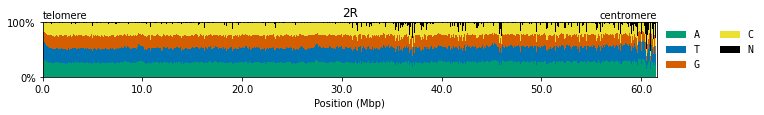

In [54]:
plot_sequence_composition('2R')

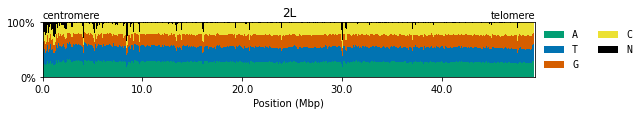

In [32]:
plot_sequence_composition('2L')

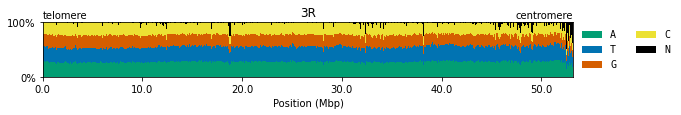

In [33]:
plot_sequence_composition('3R')

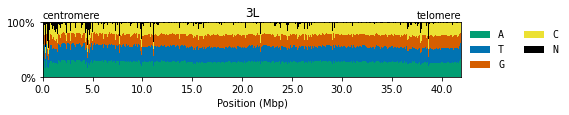

In [34]:
plot_sequence_composition('3L')

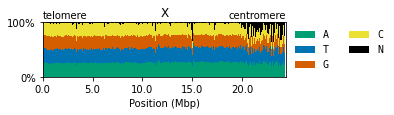

In [35]:
plot_sequence_composition('X')

A few points to note about the plots above:

1. All of the chromosome arms are made up of A, C, T and G in roughly equal proportion, although A and T are a little more common than C and G.

1. We annotated each chromosome arm with "[centromere](https://www.genome.gov/genetics-glossary/Centromere)" and "[telomere](https://www.genome.gov/genetics-glossary/Telomere)". You probably don't need to know what these mean, but it is worth knowing that the sequences at these two different ends of the chromosome tend to be quite different, especially towards the centromere. 

1. Gaps (N) are relatively uncommon, except towards the centromere of all chromosome arms where they are more common. This is typically because sequences are more repetitive towards the centromeres and so assembling the genome is more difficult. 

1. We made the size of each figure proportional to the length of the sequence. This was to help give a feeling for the relative size of the different chromosome arms. 

1. We converted the X-axis coordinates to "Mbp" which means mega-base pairs, i.e., millions of letters.

OK, now we're acquainted with the reference genome, let's look at nucleotide variation.

## SNP sites and alleles

When studying genetic variation in natural populations, there are two fundamental questions:

1. Where in the genome do we observe **differences (i.e., nucleotide variation)** between individual mosquitoes. 

2. Where in the genome do we observe **no differences (i.e., nucleotide conservation)** between individuals. 

Sometimes this second question is overlooked, but both questions are important.

In Ag1000G phase 3 we have taken a slightly different approach to calling single nucleotide polymorphisms (SNPs - single letter differences) than in previous project phases. Because we are interested in both of the above questions, we have genotyped all individual mosquitoes at all genomic sites where the reference genotype nucleotide is known (i.e., not an "N"), regardless of whether any variation is present. This is sometimes known as an "all sites" analysis. 

In order to simplify SNP calling across a large number of individuals, we also declared the set of all possible alternate (variant) SNP alleles ahead of time. Because we are analysing SNPs and we are not considering any other types of variation at this stage, then at each site in the genome there is one reference allele (i.e., the nucleotide in the reference genome) and three possible alternate alleles. E.g., at position 10 on chromosome arm 2R, the reference allele is "T", and so there are three possible alternate alleles: "A", "C" and "G".

Let's look at how these data are represented for chromosome arm 2R:

In [20]:
pos, ref, alt = ag3.snp_sites("2R")

The `pos` array here holds the 1-based positions (coordinates) where the SNPs were called. E.g., here's the first 10 SNP positions:

In [21]:
pos[:10].compute()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

Note that this is simply the positions 1-10. However, these positions **do not** continue increasing by 1 all the way through the array, i.e., there are gaps, because of gaps in the reference genome. We can quickly visualise that:

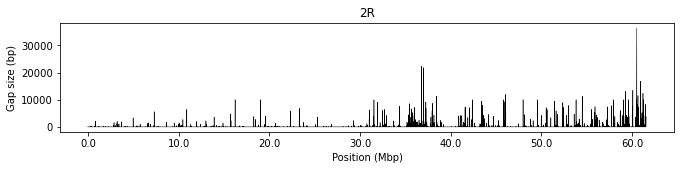

In [23]:
p = pos.compute()
d = np.diff(p)
fig, ax = plt.subplots(figsize=(11, 2))
ax.plot(p[1:], d, color='black', linewidth=.5)
ax.set_title("2R")
# convert X axis to Mbp
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: x//1e6))
ax.set_xlabel("Position (Mbp)")
ax.set_ylabel('Gap size (bp)');

Note also that the length of the `pos` array is less than the length of the reference genome sequence:

In [24]:
len(seq) - len(pos)

1412652

This difference is the number of unknown nucleotides ("N"s) in the reference genome that we computed earlier. This is another way of confirming that we have called SNP genotypes at all genomic sites where the reference genome nucleotide is known.

The `ref` array holds the reference alleles, i.e., the reference genome nucleotide for each SNP site. E.g., here's the reference alleles at the first 10 SNP sites:

In [25]:
ref[:10].compute()

array([b'C', b'T', b'C', b'T', b'A', b'A', b'A', b'C', b'A', b'T'],
      dtype='|S1')

We can confirm that this corresponds to the nucleotides in the reference sequence by using the SNP positions to index the sequence (remembering to convert to zero-based coordinates):

In [26]:
np.take(seq, pos[:10] - 1)

array([b'C', b'T', b'c', b't', b'a', b'a', b'a', b'c', b'a', b't'],
      dtype='|S1')

The `alt` array holds the predefined alternate alleles at each site. E.g., here's the alternate alleles for the first 10 SNP sites:

In [27]:
alt[:10].compute()

array([[b'A', b'T', b'G'],
       [b'A', b'C', b'G'],
       [b'A', b'T', b'G'],
       [b'A', b'C', b'G'],
       [b'C', b'T', b'G'],
       [b'C', b'T', b'G'],
       [b'C', b'T', b'G'],
       [b'A', b'T', b'G'],
       [b'C', b'T', b'G'],
       [b'A', b'C', b'G']], dtype='|S1')

Each row represents a site, and the columns show the three possible alternate alleles.

The same applies if you are working with the data in VCF format. E.g., here's the first 10 rows of the VCF file with SNP genotypes for sample AR0001-C [previously downloaded](../download), note the three alternate (ALT) alleles at every site:

In [31]:
import gzip
with gzip.open("../AR0001-C.vcf.gz", mode='rt') as f:
    count = 0
    for line in f:
        if not line.startswith("##"):
            print(line.strip())
            count += 1
        if count > 10:
            break

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	AR0001-C
2R	1	.	C	A,T,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=14.72	GT:AD:DP:GQ:PL	0/0:5,0,0,0:5:6:0,6,52,6,52,52,6,52,52,52
2R	2	.	T	A,C,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=13.44	GT:AD:DP:GQ:PL	0/0:6,0,0,0:6:6:0,6,53,6,53,53,6,53,53,53
2R	3	.	C	A,T,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=12.44	GT:AD:DP:GQ:PL	0/0:7,0,0,0:7:6:0,6,53,6,53,53,6,53,53,53
2R	4	.	T	A,C,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=12.44	GT:AD:DP:GQ:PL	0/0:7,0,0,0:7:6:0,6,53,6,53,53,6,53,53,53
2R	5	.	A	C,T,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=22.81	GT:AD:DP:GQ:PL	0/0:9,0,0,0:9:6:0,6,53,6,53,53,6,53,53,53
2R	6	.	A	C,T,G	0.02	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=28.78	GT:AD:DP:GQ:PL	0/0:10,0,0,0:10:12:0,12,113,12,113,113,12,113,113,113
2R	7	.	A	C,T,G	0.02	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=27.68	GT:AD:DP:GQ:PL	0/0:11,0,

**The most important thing to note about the SNP data in Ag3 is that not all of these alternate alleles will have been observed in the mosquitoes we sequenced.**

If you want to know which alternate alleles are observed in Ag3, you need to look at the SNP genotypes. Let's take a look at how SNP genotypes are represented, then return to the question of which alternate alleles have been observed.

## SNP genotypes

Here a SNP "genotype" means the pair of nucleotides (alleles) carried by an individual mosquito at a specific site in the genome. Note that this is a pair of alleles because mosquitoes are diploid like us, meaning that they carry two copies of their genome, one inherited from each parent (except for males on the X chromosome, more on that later).

Rather than storing the actual nucleotides for each genotype, it is conventional to use a numerical encoding of genotypes, where 0 stands for the reference allele, 1 stands for the first alternate allele, 2 stands for the second alternate allele, 3 stands for the third alternate allele, etc.

E.g., at site 2R:10 the reference allele is "T". If an individual mosquito carries a homozygous reference genotype (both genome copies have a "T"), this is represented as the pair of integers `(0, 0)`. In a VCF file this is represented as the string "0/0".

At 2R:10 we have arbitrarily declared that "A" is the first alternate allele. If an individual carries a heterozygous genotype, where one genome copy has "T" and the other has "A", this is represented as the pair `(0, 1)`. The ordering of this pair has no meaning.

Similarly, at 2R:10 we have arbitrarily declared that "C" is the second alternate allele and "G" is the third alternate allele. So, an individual homozygous for the "C" allele would be represented as `(2, 2)`, an individual homozygous for "G" would be `(3, 3)` and an individual heterozygous for the "C" and "G" alleles would be `(2, 3)`.

There's one more thing to know. Sometimes a genotype is called as missing, meaning that there were no sequence reads for the given individual at a given site. In Python we represent this as a pair of negative numbers `(-1, -1)`. In VCF this is represented as the string "./.".

To see this in action, let's access the SNP genotypes for chromosome arm 2R for all wild samples in Ag3.

In [32]:
gt = ag3.snp_genotypes("2R")
gt

,Array,Chunk
Bytes,334.82 GB,30.00 MB
Shape,"(60132453, 2784, 2)","(300000, 50, 2)"
Count,27363 Tasks,13668 Chunks
Type,int8,numpy.ndarray


The `gt` array has three dimensions. The first dimension corresponds to the genomic sites we've analysed (in this case, there are 60,132,453). The second dimension (2,784) is the number of individuals genotyped. The third dimension (2) represents the two alleles in each individual genotype.

So, e.g., let's look up the genotype call at the 10th site in the first individual:

In [34]:
gt[9, 0].compute()

array([0, 0], dtype=int8)

This is the pair `(0, 0)`, i.e., a homozygous reference genotype.

Let's try another, the 10th site and the 2,393rd individual.

In [41]:
gt[9, 2392].compute()

array([0, 2], dtype=int8)

This is a heterozygous genotype, where the reference allele and the second alternate allele are present.

One more, the 10th site and the 249th individual.

In [47]:
gt[9, 248].compute()

array([-1, -1], dtype=int8)

This is a missing genotype call.

@@TODO something about scikit-allel genotype arrays. Display. Counting genotypes. Counting alleles.